# STAT 201 Project Proposal

## Introduction

   In Canada, cancer is currently the leading cause of death annually with 2 in 5 people expected to be diagnosed once in their lifetime (Canadian Cancer Statistics, 2021). With that, gliomas are the most common malignant tumors in adults (Carrano, 2021). However, there exists certain genetic mutations that can increase the risk of cancer and enhance the progression of cancer in individuals such as the epidermal growth factor receptor (EGFR) (Xu, 2017). While EGFR mutations are known to increase risk of cancer, it is more commonly associated with lung cancer, therefore, it can be useful for clinical treatments and therapies to investigate whether a mutation in the EGFR gene impacts the severity of glioma tumors (Liu, 2020). Additionally, it has been reported that there are greater rates of incidence in men compared to women and the treatment of gliomas requires different approaches between men and women (Carrano, 2021). Hence, it is important to investigate whether there is a difference in the mean age of diagnosis between men and women to better tune screening ages accordingly. 
Thus, our two research questions are as follows: 

1) Do the proportion of patients with the most severe form of glioma, glioblastoma (GBM), differ in those with a EGFR mutation than those without?

2) Is there a significant difference in the average age of diagnosis for gliomas between men and women? 

The dataset we will be using is the Glioma Grading Clinical and Mutation Features Dataset from the UCI Machine Learning Repository. The dataset contains 24 attributes however for our analysis we are only concerned with 4 of them. 

For the first question we will be looking at Grade and EGFR:
    8) EGFR: Gene responsible for the production of the epidermal growth factor receptor (EGFR) (0 = not mutated, 1 = mutated)
    24) Grade: Glioma class information (1 = glioblastoma (GBM), 0 = low grade glioma (LGG))

For the second question we will be looking at Gender and Age_at_diagnosis:
    1) Gender: (0 = male, 1 = female)
    2) Age_at_diagnosis: age of individual at time of diagnosis in years


## Preliminary Results

In [1]:
library(tidyverse)
library(infer)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




In [2]:
glioma <- read_csv("./TCGA_InfoWithGrade.csv")

Rows: 839 Columns: 24
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (24): Grade, Gender, Age_at_diagnosis, Race, IDH1, TP53, ATRX, PTEN, EGF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Explanation of the Datset
The dataset is that of glioma patients. The clinical features are `Gender`, `Age_at_diagnosis` and `Race`, and there are a variety of binary features, whether a specific gene is mutated or not. The grade of the glioma is encoded in the `Grade` feature. A preview of the dataset is shown below.

In [3]:
head(glioma)

Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,⋯,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,51.30,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,38.72,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,35.17,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,32.78,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,31.51,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,33.21,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Variables of Interest
In this study we are interested in two things:  
1. Is there a difference in the proportions of patients with EGFR gene mutation between high grade and low grade groups?
2. Is there something we can learn about the grade of glioma patients from their age at diagnosis?

#### Patient Age at Diagnosis and Glioma Grade

In [4]:
# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
age_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
age_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
age_virtual_samples <- rbind(age_virtual_samples_0, age_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

In [5]:
# Sample distribution plot of age at diagnosis
age_sample_dist <- glioma %>%
    filter(!is.na(Age_at_diagnosis)) %>%
    mutate(Grade = as.factor(Grade)) %>%
    ggplot() + 
    geom_histogram(aes(x = Age_at_diagnosis, fill = Grade, alpha = 0.75), bins = 39) + 
    xlab("Age of Diagnosis") + 
    ggtitle("Sample Distribution of Age at Diagnosis of Glioma") +
    theme(text = element_text(size = 16))

# Plot the resulting bootstrap distributions
mean_age_bootstrap_dist <- age_virtual_samples %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 35) + 
    xlab("Mean Age at Diagnosis of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of Age at Diagnosis by Glioma Grade") + 
    theme(text = element_text(size = 16))

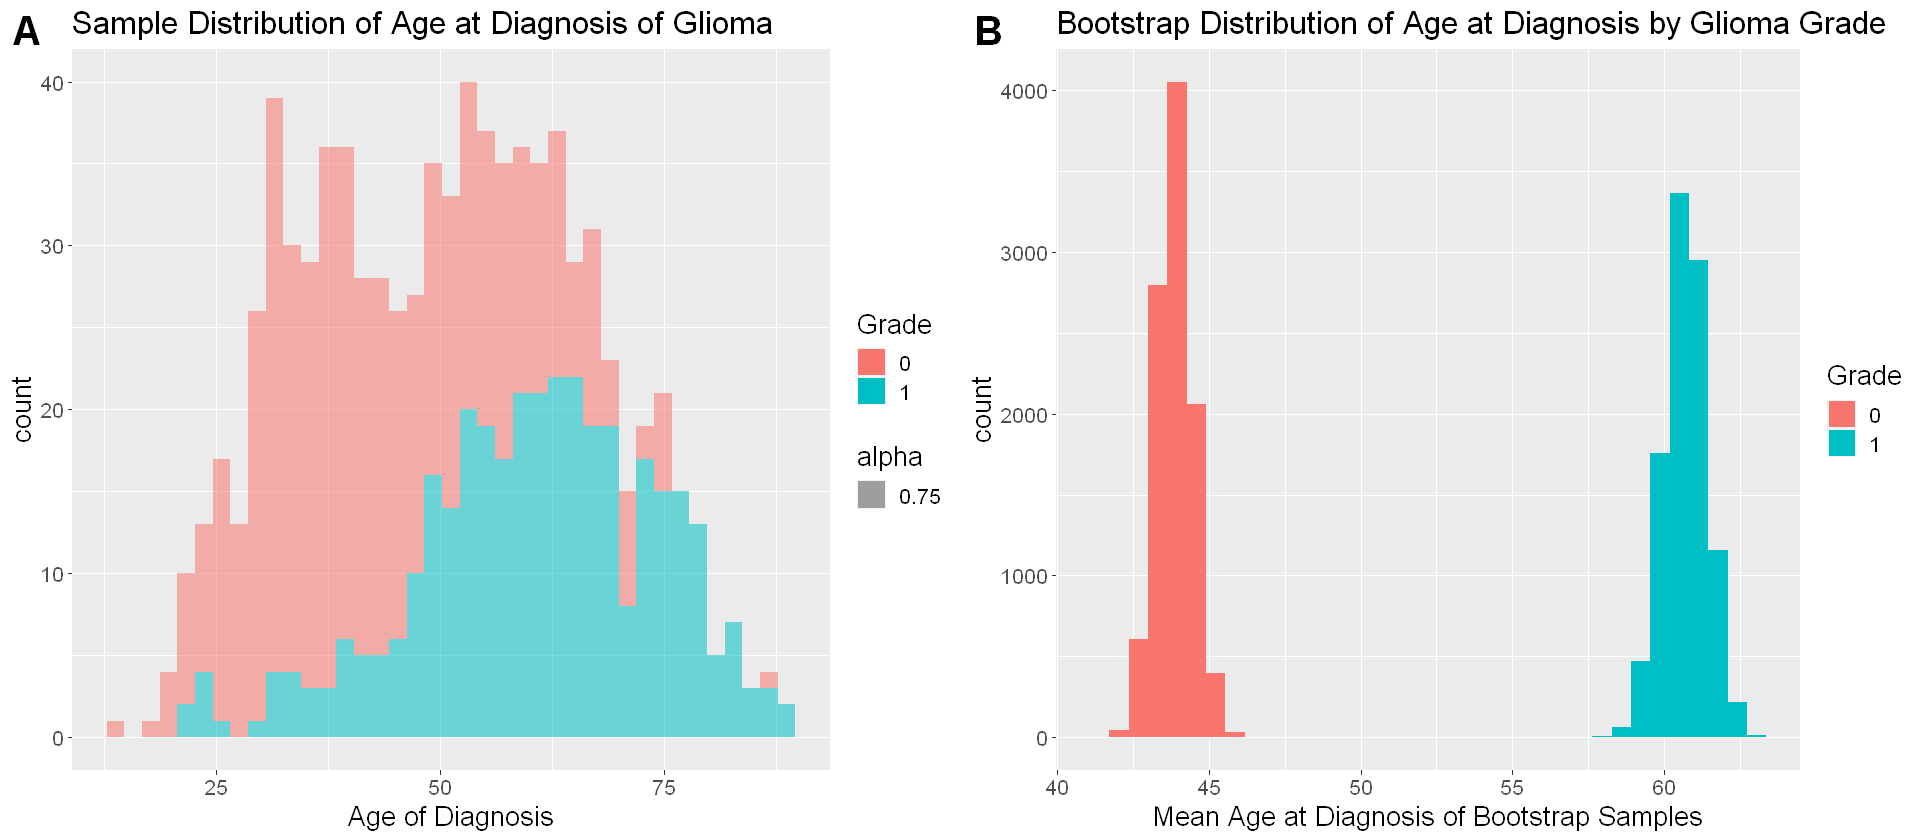

In [6]:
options(repr.plot.width = 16)
plot_grid(age_sample_dist, mean_age_bootstrap_dist, labels = c('A', 'B'), label_size = 24)

**Figure 1A:** The sample distribution of patients ages at the time of glioma diagnosis as encoded in the `Age_at_diagnosis` feature. The histograms are color coded by the glioma grade, where the red histogram indicates low grade glioma, and the cyan histogram displays the distribution of high grade glioma. The purpose of this visualization is to explore whether the sample distribution of patient age at diagnosis reveals anything about their glioma grade. For example, patients diagnosed at a later age may have a higher grade glioma. The distribution has quite a wide range, ranging from about 12 to over 85 years of age. We see majority of the high-grade glioma diagnoses are on the higher end of the distribution, whereas the lower grade gliomas are spread across in what seems to be a bimodal distribution.  
**Figure 1B:** The bootstrap distribution of patients mean age taken from 10,000 bootstrap samples. The mean age of diagnosis for patients with low grade glioma seems to be around 44, and the mean age of diagnosis for high grade glioma patients is around 61. 

#### EGFR Mutation Proportions and Glioma Grade

In [7]:
# Create a bootstrap distribution of mutated EGFR gene proportions 
egfr_virtual_bootstrap_dist <- glioma %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') 

# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
egfr_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
egfr_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
egfr_virtual_samples_by_label <- rbind(egfr_virtual_samples_0, egfr_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

In [8]:
# The plot of bootstrap samples by label
plot_by_label <- egfr_virtual_samples_by_label %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

# The plot of bootstrap samples holistically 
plot_entire <- egfr_virtual_bootstrap_dist %>%
    ggplot() + 
    geom_histogram(aes(x = stat), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

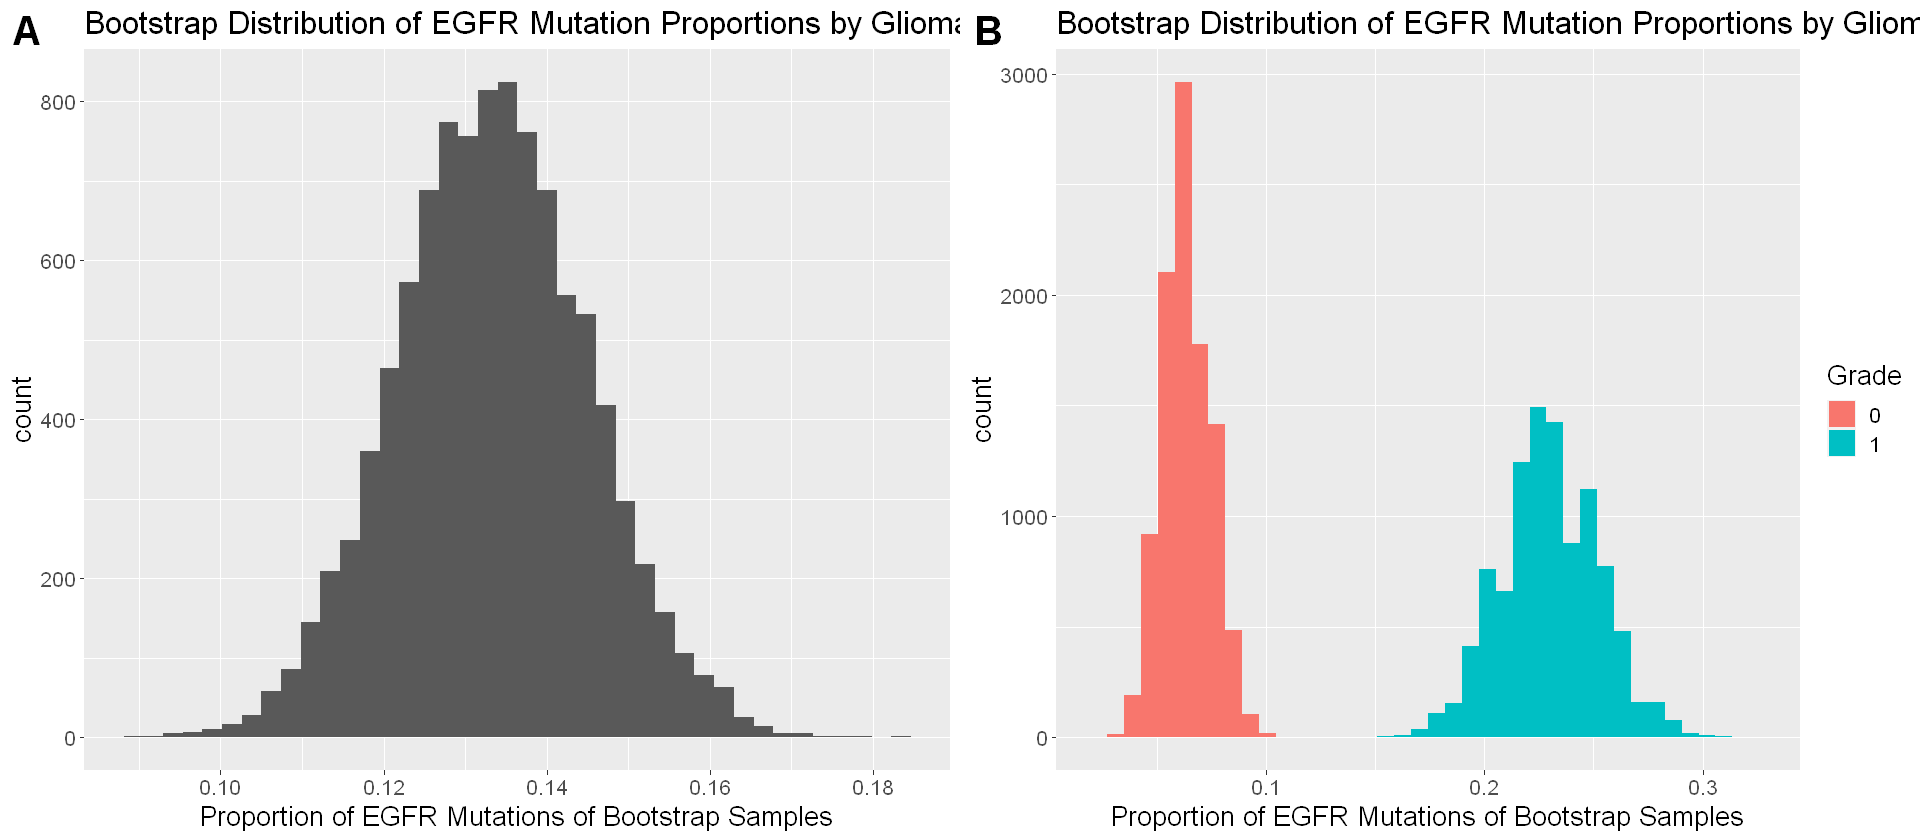

In [9]:
# Plot by grid
plot_grid(plot_entire, plot_by_label, labels = c('A', 'B'), label_size = 24) 

**Figure 2A:** The bootstrap distribution of proportions of EGFR mutations in glioma patients. The mean is around 14%, with approximately 14% of glioma patients have an EGFR gene mutation.  
**Figure 2B:** The bootstrap distribution of proportions of EGFR mutations in low grade vs high grade glioma patients. The mean for low-grade glioma patients is roughly 7%, and the mean for high-grade glioma patients is roughly 24%. This may suggest that EGFR mutations are associated with higher-grade glioma.

### Test Statistic Summary

In [10]:
egfr_bootstrap_mean_0 <- mean(egfr_virtual_samples_0$stat)
egfr_bootstrap_mean_1 <- mean(egfr_virtual_samples_1$stat)
age_bootstrap_mean_0 <- mean(age_virtual_samples_0$stat)
age_bootstrap_mean_1 <- mean(age_virtual_samples_1$stat)

In [11]:
summary.stat.table <- tibble(
    "Low-grade Glioma Patients" = c(egfr_bootstrap_mean_0, age_bootstrap_mean_0),
    "High-grade Glioma Patients" = c(egfr_bootstrap_mean_1, age_bootstrap_mean_1), 
    "Rownames" = c("Proportion EGFR Mutated (p)", "Age of Diagnosis (a)")
    )
summary.stat.table <- summary.stat.table %>%
    column_to_rownames(., var = 'Rownames')
summary.stat.table

,Low-grade Glioma Patients,High-grade Glioma Patients
,<dbl>,<dbl>
Proportion EGFR Mutated (p),0.06371889,0.2297409
Age of Diagnosis (a),43.87347048,60.7068373


At first glance, it seems there is a difference between the low-grade and high-grade glioma patients. To confirm, we will perform hypothesis testing with the following null hypotheses:  
Test one: the proportion of patients with EGFR mutations, $p$:  
* $H_0$: $p_{low-grade} = p_{high-grade}$  
* $H_A$: $p_{low-grade} \neq p_{high-grade}$  

Test two: the age of diagnosis, $a$:
* $H_0$: $a_{low-grade} = a_{high-grade}$
* $H_A$: $a_{low-grade} \neq a_{high-grade}$

## Methods

## References

Carrano, Anna, et al. “Sex-Specific Differences in Glioblastoma.” Cells, vol. 10, no. 7, 2021, p. 1783, https://doi.org/10.3390/cells10071783. 

Liu, Haijing, et al. “Spectrum of EGFR Aberrations and Potential Clinical Implications: Insights from Integrative Pan‐cancer Analysis.” Cancer Communications, vol. 40, no. 1, 2020, pp. 43–59, https://doi.org/10.1002/cac2.12005. 

“Release Notice - Canadian Cancer Statistics 2021.” Health Promotion and Chronic Disease Prevention in Canada, vol. 41, no. 11, 2021, pp. 399–399, https://doi.org/10.24095/hpcdp.41.11.09. 

Xu, Hongsheng, et al. “Epidermal Growth Factor Receptor in Glioblastoma.” Oncology Letters, vol. 14, no. 1, 2017, pp. 512–516, https://doi.org/10.3892/ol.2017.6221. 
